In [1]:

import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # "0,1,2,3" # "0"

In [2]:

import numpy as np
import h5py
import cv2, PIL
import pandas as pd
import os, sys, gc
import argparse
import torch
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd

%load_ext autoreload
%autoreload 2



In [3]:
def save_eps(img,path):
    if type(img) == torch.Tensor:
        img = img.cpu().numpy()
    img = (img-img.min())/(img.max()-img.min())
    img = PIL.Image.fromarray((img*255).astype('uint8'))
    img.save(path,dpi=(300,300),mode='EPS')

In [4]:
folder_name = "./N2N_output_230917/figure"
os.makedirs(folder_name, exist_ok=True)


In [5]:
pd_metric = pd.read_csv(f"{folder_name}/metric_patch.csv")
pd_metric

,Unnamed: 0,N2N_F01-F01_FBI_Net_EMSE_Affine,N2N_F01-F01_FBI_Net,RN2N_F01-F02_FBI_Net,RN2N_F01-F04_FBI_Net,RN2N_F01-F08_FBI_Net,RN2N_F01-F32_FBI_Net,N2N_F01-F01_FBI_Net_N2V,N2N_F01-F01_NAFNet_light,RN2N_F01-F02_NAFNet_light,RN2N_F01-F04_NAFNet_light,RN2N_F01-F08_NAFNet_light
0,before_PSNR_mean,12.221937,12.221937,12.221937,12.221937,12.221937,12.221937,12.221937,12.221937,12.221937,12.221937,12.221937
1,before_SSIM_mean,0.037755,0.037755,0.037755,0.037755,0.037755,0.037755,0.037755,0.037755,0.037755,0.037755,0.037755
2,PSNR_mean,16.896773,21.042796,21.411013,21.481494,20.742133,19.058081,16.898795,20.868667,20.758451,21.451990,20.631640
3,SSIM_mean,0.121746,0.455178,0.456409,0.457746,0.455400,0.453170,0.119206,0.455227,0.456306,0.457278,0.455770
4,median_PSNR_mean,24.560095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,median_SSIM_mean,0.451422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# drop last 4 columns
pd_metric = pd_metric.iloc[:,:-4]

In [7]:
pd_metric

,Unnamed: 0,N2N_F01-F01_FBI_Net_EMSE_Affine,N2N_F01-F01_FBI_Net,RN2N_F01-F02_FBI_Net,RN2N_F01-F04_FBI_Net,RN2N_F01-F08_FBI_Net,RN2N_F01-F32_FBI_Net,N2N_F01-F01_FBI_Net_N2V
0,before_PSNR_mean,12.221937,12.221937,12.221937,12.221937,12.221937,12.221937,12.221937
1,before_SSIM_mean,0.037755,0.037755,0.037755,0.037755,0.037755,0.037755,0.037755
2,PSNR_mean,16.896773,21.042796,21.411013,21.481494,20.742133,19.058081,16.898795
3,SSIM_mean,0.121746,0.455178,0.456409,0.457746,0.455400,0.453170,0.119206
4,median_PSNR_mean,24.560095,NaN,NaN,NaN,NaN,NaN,NaN
5,median_SSIM_mean,0.451422,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
pd_metric.rename(columns={'Unnamed: 0':'metric',
                          'N2N_F01-F01_FBI_Net_EMSE_Affine' : 'FBI-denoiser',
                          'N2N_F01-F01_FBI_Net' : 'N2N F01-F01',
                          'RN2N_F01-F02_FBI_Net' : 'RN2N F01-F02',
                          'RN2N_F01-F04_FBI_Net' : 'RN2N F01-F04',
                          'RN2N_F01-F08_FBI_Net' : 'RN2N F01-F08',
                          'RN2N_F01-F32_FBI_Net' : 'Supervised Learning (F01-F32)',
                          'N2N_F01-F01_FBI_Net_N2V' : 'N2V'}, inplace=True)
pd_metric[:-2]

,metric,FBI-denoiser,N2N F01-F01,RN2N F01-F02,RN2N F01-F04,RN2N F01-F08,Supervised Learning (F01-F32),N2V
0,before_PSNR_mean,12.221937,12.221937,12.221937,12.221937,12.221937,12.221937,12.221937
1,before_SSIM_mean,0.037755,0.037755,0.037755,0.037755,0.037755,0.037755,0.037755
2,PSNR_mean,16.896773,21.042796,21.411013,21.481494,20.742133,19.058081,16.898795
3,SSIM_mean,0.121746,0.455178,0.456409,0.457746,0.455400,0.453170,0.119206


In [9]:
# model_metric = pd_metric.T
model_metric = pd_metric.T.iloc[:,:-2]
model_metric

,0,1,2,3
metric,before_PSNR_mean,before_SSIM_mean,PSNR_mean,SSIM_mean
FBI-denoiser,12.221937,0.037755,16.896773,0.121746
N2N F01-F01,12.221937,0.037755,21.042796,0.455178
RN2N F01-F02,12.221937,0.037755,21.411013,0.456409
RN2N F01-F04,12.221937,0.037755,21.481494,0.457746
RN2N F01-F08,12.221937,0.037755,20.742133,0.4554
Supervised Learning (F01-F32),12.221937,0.037755,19.058081,0.45317
N2V,12.221937,0.037755,16.898795,0.119206


In [10]:
model_metric.columns = model_metric.iloc[0]
model_metric = model_metric.iloc[1:]
model_metric

metric,before_PSNR_mean,before_SSIM_mean,PSNR_mean,SSIM_mean
FBI-denoiser,12.221937,0.037755,16.896773,0.121746
N2N F01-F01,12.221937,0.037755,21.042796,0.455178
RN2N F01-F02,12.221937,0.037755,21.411013,0.456409
RN2N F01-F04,12.221937,0.037755,21.481494,0.457746
RN2N F01-F08,12.221937,0.037755,20.742133,0.4554
Supervised Learning (F01-F32),12.221937,0.037755,19.058081,0.45317
N2V,12.221937,0.037755,16.898795,0.119206


In [11]:
median_filter_metric = pd.DataFrame({'median_filter' : {'PSNR_mean' : '24.560095', 'SSIM_mean' : '0.451422' }}).T
median_filter_metric

,PSNR_mean,SSIM_mean
median_filter,24.560095,0.451422


In [12]:
model_metric.append(median_filter_metric)

/tmp/ipykernel_117994/2414728669.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_metric.append(median_filter_metric)


,before_PSNR_mean,before_SSIM_mean,PSNR_mean,SSIM_mean
FBI-denoiser,12.221937,0.037755,16.896773,0.121746
N2N F01-F01,12.221937,0.037755,21.042796,0.455178
RN2N F01-F02,12.221937,0.037755,21.411013,0.456409
RN2N F01-F04,12.221937,0.037755,21.481494,0.457746
RN2N F01-F08,12.221937,0.037755,20.742133,0.4554
Supervised Learning (F01-F32),12.221937,0.037755,19.058081,0.45317
N2V,12.221937,0.037755,16.898795,0.119206
median_filter,NaN,NaN,24.560095,0.451422


In [13]:
cost = {'cost' : { 'FBI-denoiser' : 1.4,
            'N2N F01-F01' : 2,
            'RN2N F01-F02' : 3,
             'RN2N F01-F04' : 5,
            'RN2N F01-F08' : 9,
            'Supervised Learning (F01-F32)' : 33,
            'N2V' : 1}
}

In [14]:
pd.DataFrame(cost)

,cost
FBI-denoiser,1.4
N2N F01-F01,2.0
N2V,1.0
RN2N F01-F02,3.0
RN2N F01-F04,5.0
RN2N F01-F08,9.0
Supervised Learning (F01-F32),33.0


In [15]:
model_metric['cost'] = cost['cost'].values()
model_metric

/tmp/ipykernel_117994/3978071083.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_metric['cost'] = cost['cost'].values()


metric,before_PSNR_mean,before_SSIM_mean,PSNR_mean,SSIM_mean,cost
FBI-denoiser,12.221937,0.037755,16.896773,0.121746,1.4
N2N F01-F01,12.221937,0.037755,21.042796,0.455178,2.0
RN2N F01-F02,12.221937,0.037755,21.411013,0.456409,3.0
RN2N F01-F04,12.221937,0.037755,21.481494,0.457746,5.0
RN2N F01-F08,12.221937,0.037755,20.742133,0.4554,9.0
Supervised Learning (F01-F32),12.221937,0.037755,19.058081,0.45317,33.0
N2V,12.221937,0.037755,16.898795,0.119206,1.0


In [16]:
model_metric.T.keys().values

array(['FBI-denoiser', 'N2N F01-F01', 'RN2N F01-F02', 'RN2N F01-F04',
       'RN2N F01-F08', 'Supervised Learning (F01-F32)', 'N2V'],
      dtype=object)

In [17]:
model_metric.to_csv(f"{folder_name}/tradeoff_graph.csv")

['FBI-denoiser' 'N2N F01-F01' 'RN2N F01-F02' 'RN2N F01-F04' 'RN2N F01-F08'
 'Supervised Learning (F01-F32)' 'N2V']


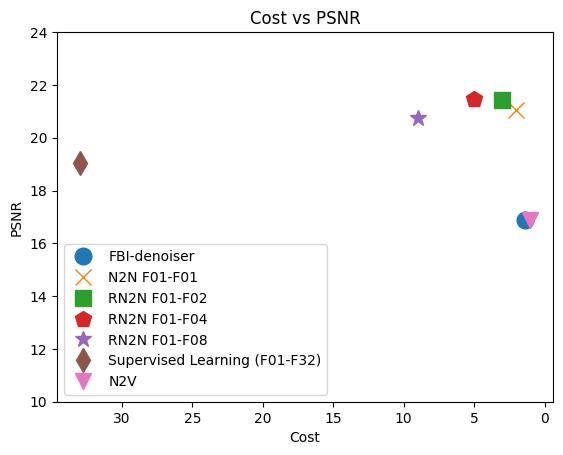

In [25]:
# plt.plot(model_metric['cost'], model_metric['PSNR_mean'], 'o')
markers = ['o', 'x',  's', 'p', '*', 'd','v']
print(model_metric.T.keys().values)
plt.ylim(10, 24)
# plt.xlim(0, 40)
plt.textsize = 13
plt.xlabel('Cost')
plt.ylabel('PSNR')
plt.labeltext = 13
plt.title('Cost vs PSNR')
# plt.yscale('log')
plt.gca().invert_xaxis()

for i in range(len(model_metric)):
    plt.plot(model_metric['cost'][i], model_metric['PSNR_mean'][i], markers[i], label=model_metric.T.keys().values[i],
             markersize=12)
plt.legend(model_metric.T.keys().values)#, loc='upper right')
plt.savefig(f"{folder_name}/cost_vs_PSNR.png", dpi=300)

In [19]:
import PIL 
img = PIL.Image.open(f"{folder_name}/cost_vs_PSNR.png")
img = img.convert('CMYK')

img.save(f'{folder_name}/cost_vs_PSNR.eps',dpi=(300,300),mode='EPS')